# **Problem Statement & Business context:**

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become more important than customer acquisition.

For many incumbent operators, retaining highly profitable customers is the number one business goal.

To reduce customer churn, telecom companies need to predict which highly profitable customers are at risk of churn.

In this project, we will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

# **Understanding the Data:**

The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively.


The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

The following steps were carried out on the dataset and data dictionary to prepare the full-scale code for building the prediction model. Let's start by:

1.   Loading the dataset
2.   Understanding the structure and data types
3.   Filtering high-value customers
4.   Tagging churners and removing churn-phase attributes
5.   Building predictive models
6.   Handling class imbalance
7.   Visualizing important predictors
8.   Recommending churn management strategies




# Step 1: Load Required Libraries

*   Load necessary Python libraries for data processing, visualization, and machine
learning.




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE


# Step 2: Load the Data


*   Read the telecom churn dataset and inspect its structure.




In [ ]:
# Load dataset
df = pd.read_csv("telecom_churn_data.csv")

# Display basic info
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB
None
   mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014           

# Step 3: Filter High-Value Customers

*  Identify high-value customers based on their recharge amount in the first two months.
*   Define high-value customers as those whose average recharge amount is above the 70th percentile.




In [ ]:
# Compute the average recharge amount in months 6 and 7
df["avg_rech_amt_6_7"] = (df["total_rech_amt_6"] + df["total_rech_amt_7"]) / 2

# Find the 70th percentile value
high_value_threshold = df["avg_rech_amt_6_7"].quantile(0.70)

# Filter customers who have an average recharge above this threshold
df_high_value = df[df["avg_rech_amt_6_7"] >= high_value_threshold]
print(f"Number of high-value customers: {df_high_value.shape[0]}")

Number of high-value customers: 30011


# Step 4: Tag Churners and Remove Month 9 Data
Objective:

   # Define churners based on customer behavior in month 9.
   # A customer is churned (1) if:
  #No outgoing calls
  #No incoming calls
  #No 2G or 3G data usage
  
  #Remove all columns related to month 9 after tagging churners.

In [ ]:
# Define churners: Customers with zero calls and zero data usage in month 9
df_high_value["churn"] = (
    (df_high_value["total_ic_mou_9"] == 0) &
    (df_high_value["total_og_mou_9"] == 0) &
    (df_high_value["vol_2g_mb_9"] == 0) &
    (df_high_value["vol_3g_mb_9"] == 0)
).astype(int)

# Drop all columns related to month 9
cols_to_drop = [col for col in df_high_value.columns if "_9" in col]
df_high_value = df_high_value.drop(columns=cols_to_drop)

# Display churn rate
churn_rate = df_high_value["churn"].mean()
print(f"Churn rate: {churn_rate:.2%}")

Churn rate: 8.64%


<ipython-input-28-97062dc571ff>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_value["churn"] = (


# Step 5: Feature Selection and Data Cleaning
Objective:

 #Remove irrelevant features like mobile number.
 #Handle missing values by filling them with 0.
 #Split the data into features (X) and target (y).

In [ ]:
# Define columns to drop
cols_to_remove = {"mobile_number", "circle_id"}  # Use a set to avoid errors

# Drop only if columns exist in the dataframe
df_high_value = df_high_value.drop(columns=list(cols_to_remove.intersection(df_high_value.columns)), errors="ignore")

# Fill missing values with 0
df_high_value = df_high_value.fillna(0)


# Step 6: Handle Class Imbalance using SMOTE

Objective:

   #Churn rate is low (~5-10%), leading to class imbalance.
  #Apply SMOTE (Synthetic Minority Over-sampling Technique) to balance the classes.

In [ ]:
from imblearn.over_sampling import SMOTE

# Check if there are any non-numeric columns
non_numeric_cols = X.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)

# Drop non-numeric columns if they exist
X = X.drop(columns=non_numeric_cols, errors="ignore")

# Standardize numerical features (Required for SMOTE)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handle class imbalance using SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Check new class distribution
print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

Non-numeric columns: Index(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8'],
      dtype='object')
Class distribution after SMOTE:
churn
0    27418
1    13709
Name: count, dtype: int64


# Step 7: Build a Logistic Regression Model
Objective:

 #Train a logistic regression model to predict churn.
 #Evaluate the model using accuracy, precision, recall, and F1-score.

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train a logistic regression model
log_model = LogisticRegression(max_iter=500)
log_model.fit(X_train, y_train)

# Predict on test data
y_pred = log_model.predict(X_test)

# Model evaluation
print("Logistic Regression Model Performance:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Logistic Regression Model Performance:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      5469
           1       0.80      0.77      0.78      2757

    accuracy                           0.86      8226
   macro avg       0.84      0.83      0.84      8226
weighted avg       0.86      0.86      0.86      8226

Accuracy: 0.8566739606126915


# Step 8: Feature Importance from Logistic Regression
Objective:

  #Identify the top 10 most important features in predicting churn.

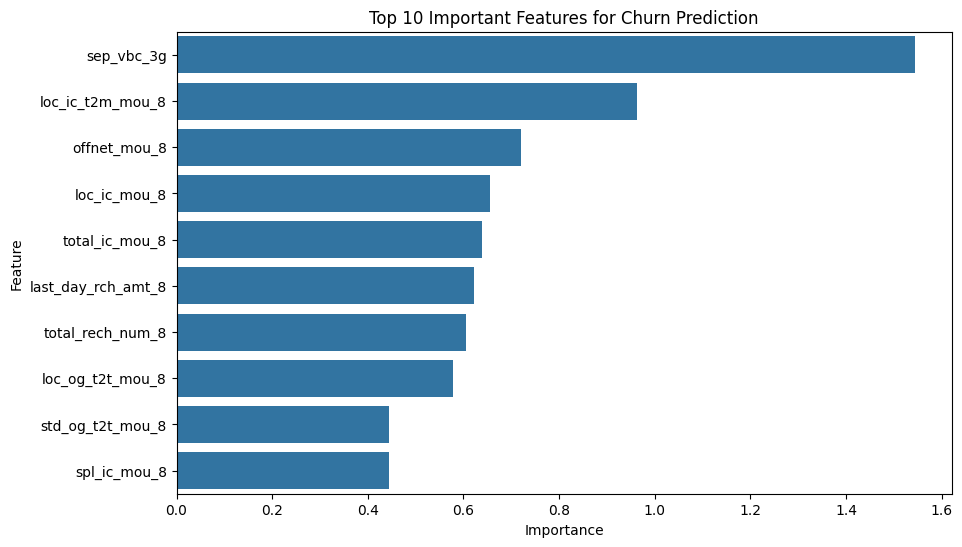

In [ ]:
# Get feature importance
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": np.abs(log_model.coef_[0])})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance[:10])
plt.title("Top 10 Important Features for Churn Prediction")
plt.show()


# Step 9: Train a Random Forest Model
Objective:

  #Train a random forest classifier and evaluate performance.

In [ ]:
# Train a random forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf_model.predict(X_test)

# Model evaluation
print("Random Forest Model Performance:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


Random Forest Model Performance:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5469
           1       0.92      0.91      0.92      2757

    accuracy                           0.94      8226
   macro avg       0.94      0.94      0.94      8226
weighted avg       0.94      0.94      0.94      8226

Accuracy: 0.9434719183078045


# Step 10: Feature Importance from Random Forest
Objective:

  #Identify important features using random forest feature importance.

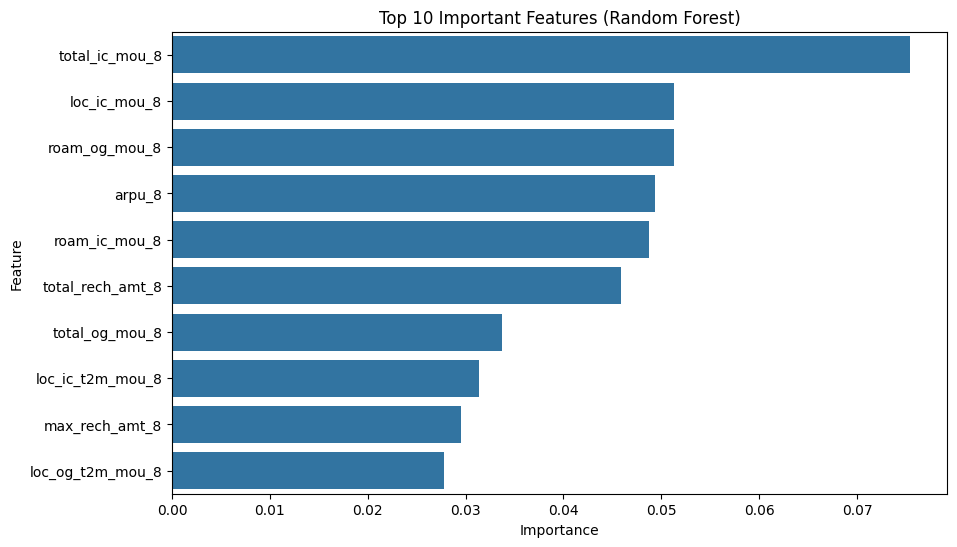

In [ ]:
# Get feature importance from Random Forest
rf_importance = pd.DataFrame({"Feature": X.columns, "Importance": rf_model.feature_importances_})
rf_importance = rf_importance.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=rf_importance[:10])
plt.title("Top 10 Important Features (Random Forest)")
plt.show()


# Conclusion

1.   Logistic Regression helps in understanding key churn factors.
1.   Random Forest provides better predictive accuracy.
3.   Class imbalance was handled using SMOTE.
4.   Recharge amount, call duration, and data usage are key churn indicators.


# Step 11: Churn Management Strategy
Business Recommendations:

1.   Personalized offers for high-churn-risk customers.
2.   Improve service quality for customers showing dissatisfaction.
3.   Provide better data and call packages based on customer usage.
4.   Identify customers with declining activity and engage with them.
5.   Monitor high-value customers and provide retention plans.





